<a href="https://colab.research.google.com/github/katearb/Data-Science-Notebooks/blob/master/1_LanguageModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced NLP HW0

Before starting the task please read thoroughly these chapters of Speech and Language Processing by Daniel Jurafsky & James H. Martin:

•	N-gram language models: https://web.stanford.edu/~jurafsky/slp3/3.pdf

•	Neural language models: https://web.stanford.edu/~jurafsky/slp3/7.pdf 

In this task you will be asked to implement the models described there.

Build a text generator based on n-gram language model and neural language model.
1.	Find a corpus (e.g. http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt ), but you are free to use anything else of your interest
2.	Preprocess it if necessary (we suggest using nltk for that)
3.	Build an n-gram model
4.	Try out different values of n, calculate perplexity on a held-out set
5.	Build a simple neural network model for text generation (start from a feed-forward net for example). We suggest using tensorflow + keras for this task

Criteria:
1.	Data is split into train / validation / test, motivation for the split method is given
2.	N-gram model is implemented
  *	Unknown words are handled
  * Add-k Smoothing is implemented
3.	Neural network for text generation is implemented
4.	Perplexity is calculated for both models
5.	Examples of texts generated with different models are present and compared
6.	Optional: Try both character-based and word-based approaches.

In [ ]:
import math
import random
import re
import requests
from typing import Iterable, Union, Tuple, List
from functools import wraps, reduce

import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import pandas as pd
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Text preprocessing

In [ ]:
# loading data
link = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
f = requests.get(link)
data = f.text

In [ ]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
data_train, data_test = ''.join(data_train), ''.join(data_test)

Data was splitted in a such proportion because we have a lot of data, so 80% seems to be right.
It was also important not to shuffle the data, because the word order will be broken in this case.

In [ ]:
class TextPreprocesser:
  def _remove_special_characters(self,
                                 text: str
                                ) -> str:
    """
    This methods removes punctuation characters, except for . ! ?
    """
    pattern_separators = re.compile(r"\n+|(?<=\w)'(?=\w)?")
    text = re.sub(pattern_separators, ' ', text)
    
    pattern_punctuation = re.compile(r'[^A-Za-z .!?]')
    text = re.sub(pattern_punctuation, '', text)
    
    return text
  
  def _add_end_symbols(self,
                       text: str
                      ) -> str:
    text_copy = ['<s>']
    for i, token in enumerate(text):
        if token in '.?!':
            text_copy.extend(['</s>', '<s>'])
        else:
            text_copy.append(token)
    
    return text_copy
      
  def preprocess(self, 
                 text: str
                ) -> List[str]:
    """
    This method turns text into a token list.
    """
    # lower case
    text = text.lower()
    
    # remove non-termination punctuation (, - : ; " etc.)
    text = self._remove_special_characters(text)
    
    # tokenization
    text = word_tokenize(text)
    
    # create end-symbols intead of .!?
    text = self._add_end_symbols(text)
    
    return text

In [ ]:
t = TextPreprocesser()

In [ ]:
prep_text = t.preprocess(data_train)

In [ ]:
# preprocessed text
' '.join(prep_text[:1000])

'<s> first citizen before we proceed any further hear me speak </s> <s> all speak speak </s> <s> first citizen you are all resolved rather to die than to famish </s> <s> all resolved </s> <s> resolved </s> <s> first citizen first you know caius marcius is chief enemy to the people </s> <s> all we know t we know t. first citizen let us kill him and we ll have corn at our own price </s> <s> is t a verdict </s> <s> all no more talking on t let it be done away away </s> <s> second citizen one word good citizens </s> <s> first citizen we are accounted poor citizens the patricians good </s> <s> what authority surfeits on would relieve us if they would yield us but the superfluity while it were wholesome we might guess they relieved us humanely but they think we are too dear the leanness that afflicts us the object of our misery is as an inventory to particularise their abundance our sufferance is a gain to them let us revenge this with our pikes ere we become rakes for the gods know i speak 

## Custom ngram model

Base class for the model.

In [ ]:
class BaseLM:
  def _check_fit(func):
      """
      A helper decorator that ensures that the LM was fit on vocab.
      """
      @wraps(func)
      def wrapper(self,*args,**kwargs):
          if not self.is_fitted:
              raise AttributeError(f"Fit model before call {func.__name__} method")
          return func(self, *args,**kwargs)
      return wrapper

  def __init__(self, 
               n: int, 
               vocab: Iterable[str] = None, 
               unk_label: str = "<UNK>"
              ):
      """
      Language model constructor
      n -- n-gram size
      vocab -- optional fixed vocabulary for the model
      unk_label -- special token that stands in for so-called "unknown" items
      """
      self.n = n
      self._vocab = vocab if vocab else None
      self.unk_label = unk_label
      self.is_fitted = False
      
      self._contexts_freqs = {}
      self._n_grams_freqs = {}
      self._ngram_probs = {}
      self._ngram_probs_with_smoothing = {}

  def _lookup(self, 
              words: Union[str, Iterable[str]]
             ) -> Union[str, Tuple[str]]:
      """
      Look ups words in the vocabulary
      """        
      if isinstance(words, str):
          return words if words in self._vocab

      if isinstance(words, Iterable):
          return [word for word in words if word in self._vocab]
      
      raise ValueError
      

  @_check_fit
  def prob(self, 
           word: str, 
           context: Tuple[str] = None
          ) -> float:
      """
      This method returns probability of a word with given context: P(w_t | w_{t - 1}...w_{t - n + 1})

      For example:
      >>> lm.prob('hello', context=('world',))
      0.99988
      """
      if not isinstance(word, str) or not isinstance(context, tuple):
          raise ValueError

      return self._n_grams_freqs[(context, word)] / self._contexts_freqs[context]

  def prob_with_smoothing(self, 
                          word: str, 
                          context: Tuple[str] = None, 
                          alpha: float = 1.0
                          ) -> float:
      """
      Proabaility with Additive smoothing

      see: https://en.wikipedia.org/wiki/Additive_smoothing
      where:
      x - count of word in context
      N - total
      d - vocab size
      a - alpha

      """
      n_gram_freq = self._n_grams_freqs[(context, word)]
      context_freq = self._contexts_freqs[context]
      return (n_gram_freq + alpha) / (context_freq + alpha * len(self._vocab))
      
  def _find_variants(self, 
                     context:Iterable,
                     prob: str,
                     k: int) -> list:
    """
    This method finds possible n_grams based on the givn context
    """
    variants = []
    prob = self._ngram_probs if prob == 'prob' else self._ngram_probs_with_smoothing
      
    while not variants:
        variants = [(n_gram, prob[n_gram]) for n_gram in self._ngram_probs if n_gram[0][-k:] == context]
        k -= 1
        if k == 0:
            k = -self.n # context becomes () and all n-grams become variants
                        # (as context () is contained in all n_grams)
        context = context[1:]
    return variants

  @_check_fit
  def generate(self, 
               text_length: int, 
               text_seed: Iterable[str] = None,
               random_seed: Union[int, random.Random] = 42,
               prob_method: str = 'prob'
              ) -> List[str]:
    """
    This method generates text of a given length. 

    text_length: int -- Length for the output text including `text_seed`.
    text_seed: List[str] -- Given text to calculate probas for next words.
    prob_method: str -- Specifies what method to use: with or without smoothing.

    For example
    >>> lm.generate(2)
    ["hello", "world"]

    """
    random.seed(random_seed)

    if not isinstance(text_length, int) or \
            (text_seed and not isinstance(text_seed, Iterable)):
        raise ValueError
          
    if text_seed is None:
      context_counts = sum(self._contexts_freqs.values())
      weights = [con_freq / context_counts for con_freq in self._contexts_freqs.values()]
      contexts = list(self._contexts_freqs.keys())

      context = random.choices(contexts, weights=weights)
      text_seed = context[0]

    if prob_method not in ['prob', 'prob_with_smoothing']:
      raise NotImplementedError
  
    text = list(text_seed)
    k = self.n - 1

    while text_length > len(text):
        context = tuple(text[-k:])
        variants = self._find_variants(context, prob_method, k)
        choice = random.choices(variants, weights=[v[1] for v in variants])[0]
        text.append(choice[0][1])
        
    return text
      
  def update_vocab(self, 
                   sequence_of_tokens: Iterable[str]
                  ):
    """
    This method adds tokens from the sequence to self._vocab if it is not
    preseted there
    """
    if not self._vocab:
        self._vocab = []
    for token in sequence_of_tokens:
        if not self._lookup(token):
            self._vocab.append(token)
      
  def _check_unk_label_in_vocab(self):
    """
    This method adds unknown label to self._vocab if it is not presented there
    """
    if not self._lookup(self.unk_label):
        self._vocab.append(self.unk_label)
  
  def _label_unk_tokens(self, 
                        sequence_of_tokens: Iterable[str]
                        ) -> List[str]:
    """
    This method labels words which are not contained in self._vocab as self.ink_label
    """
    return [token if self._lookup(token) else self.unk_label for token in sequence_of_tokens]
  
  def _create_ngrams(self, 
                      sequence: Iterable[str]
                    ) -> List[tuple]:
    """
    This method creates list of n_grams based on the given sequence
    return: [(context, target_word)]
    """
    n = self.n
    return [(tuple(sequence[i:i+n-1]), sequence[i+n-1]) for i in range(len(sequence)-n)]
  
  def _count_n_grams_freqs(self, 
                            n_grams: Iterable[tuple]
                          ):
    """
    This method counts frequencies of n-grams
    """
    for n_gram in n_grams:
      self._n_grams_freqs[n_gram] = self._n_grams_freqs.get(n_gram, 0) + 1
  
  def _count_contexts_freqs(self, 
                            n_grams: Iterable[tuple]
                           ):
    """
    This method counts frequencies of contexts (i.e. n_gram without the last word)
    """
    contexts = [n_gram[0] for n_gram in n_grams]
    for context in contexts:
        self._contexts_freqs[context] = self._contexts_freqs.get(context, 0) + 1
          
  def _calculate_n_grams_probs(self):
    """
    This method calculates probabilities (with and without smoothing)
    of n-grams based on self._n_grams_freqs
    """
    for n_gram in self._n_grams_freqs:
      context, target_word = n_gram[0], n_gram[1]
      self._ngram_probs[n_gram] = self.prob(target_word, context)
      self._ngram_probs_with_smoothing[n_gram] = self.prob_with_smoothing(target_word, 
                                                                          context)

  def fit(self, 
          sequence_of_tokens: Iterable[str]
         ):
      """
      This method learns probabilities based on given sequence of tokens and
      updates `self.vocab`.

      sequence_of_tokens -- iterable of tokens

      For example
      >>> lm.update(['hello', 'world'])
      """      
      if self._vocab:
          self._check_unk_label_in_vocab()
          sequence_of_tokens = self._label_unk_tokens(sequence_of_tokens)
      else:
          self.update_vocab(sequence_of_tokens)

      n_grams = self._create_ngrams(sequence_of_tokens)
      self._count_n_grams_freqs(n_grams)
      self._count_contexts_freqs(n_grams)
      self.is_fitted = True
      self._calculate_n_grams_probs()
      
  @_check_fit  
  def perplexity(self, 
                 sequence_of_tokens: Union[Iterable[str], Iterable[Tuple[str]]]
                 ) -> float:
      """
      This method returns perplexity for a given sequence of tokens

      sequence_of_tokens -- iterable of tokens
      """
      probs = []
      
      for i in range(self.n, len(sequence_of_tokens)+1):
        n_gram = (tuple(sequence_of_tokens[i-self.n:i-1]), sequence_of_tokens[i-1])
        probs.append(self._ngram_probs_with_smoothing.get(n_gram, 0))
      if 0 in probs:
        return math.inf
      
      return reduce(lambda x, y: x*y, probs) ** (-1/ len(probs))


In [ ]:
print('Model based on 2-grams')
text_generator = BaseLM(2)
text_generator.fit(prep_text)
print('Perplexity of "first citizen"', text_generator.perplexity(['first', 'citizen']))
gen_text = text_generator.generate(30, ['we', 'll'], prob_method='prob_with_smoothing')
print('30-tokens-long text beginning with "we ll":', ' '.join(gen_text), sep='\n')
text_generator.perplexity(gen_text)
print('Perplexity:', text_generator.perplexity(gen_text))
print('--------------------')
gen_text = text_generator.generate(50, prob_method='prob_with_smoothing')
print('50-tokens-long text with empty text_seed:', ' '.join(gen_text), sep='\n')
print('Perplexity:', text_generator.perplexity(gen_text))

Model based on 2-grams
Perplexity of "first citizen" 385.0967741935484
30-tokens-long text beginning with "we ll":
we ll question asked her face if heaven must have all the points of his own to time </s> <s> talbot sir see her brow to parley of the world
Perplexity: 1408.9339333505075
--------------------
50-tokens-long text with empty text_seed:
wise and wrath and means your main </s> <s> second lord i must be she weeps for her parentage of drops </s> <s> he carried away </s> <s> sands i hold upto a massy as on speedy scouts </s> <s> edgar i the bowels of a mile before our entrance
Perplexity: 1476.3315468827705


In [ ]:
print('Model based on 3-grams')
text_generator = BaseLM(3)
text_generator.fit(prep_text)
print('Perplexity of "first citizen"', text_generator.perplexity(['first', 'citizen', 'll']))
gen_text = text_generator.generate(30, ['we', 'll'], prob_method='prob_with_smoothing')
print('30-tokens-long text beginning with "we ll":', ' '.join(gen_text), sep='\n')
text_generator.perplexity(gen_text)
print('Perplexity:', text_generator.perplexity(gen_text))
print('--------------------')
gen_text = text_generator.generate(50, prob_method='prob_with_smoothing')
print('50-tokens-long text with empty text_seed:', ' '.join(gen_text), sep='\n')
print('Perplexity:', text_generator.perplexity(gen_text))

Model based on 3-grams
Perplexity of "first citizen" inf
30-tokens-long text beginning with "we ll":
we ll bring him in the wild and yet his pride and salt that season a man there s meaning in his motion </s> <s> he could not believe them
Perplexity: 6905.567270370031
--------------------
50-tokens-long text with empty text_seed:
thing yea a very doleful tune how a jest </s> <s> a health </s> <s> carry them and show what s come from pisa and is tybalt </s> <s> sands sir thomas </s> <s> hamlet it is casca one incorporate to our noble acceptance of them all </s> <s> hortensio
Perplexity: 6405.953628877228


## neural network model for text generation 

In [ ]:
class Encoder:
    def __init__(self):
        self.encode_storage = {}
        self.decode_storage = {}
        self.is_fitted = False
        
    def _check_fit(func):
        """
        A helper decorator that ensures that the LM was fit on vocab.
        """
        @wraps(func)
        def wrapper(self,*args,**kwargs):
            if not self.is_fitted:
                raise AttributeError(f"Fit model before call {func.__name__} method")
            return func(self, *args,**kwargs)
        return wrapper
        
    def fit(self, 
            sequence: Iterable[str]
           ):
      """
      This methods fills up the storages
      """
      for token in sequence:
        try:
            self.encode_storage[token]
        except KeyError:
            token_id = len(self.encode_storage)
            self.encode_storage[token] = token_id
            self.decode_storage[token_id] = token
      self.is_fitted = True
      
    @_check_fit
    def encode(self, 
               sequence: Iterable[str]
              ):
      """
      This method encodes sequence of strings based on the storage
      """
      return np.array([self.encode_storage[token] for token in sequence])
    
    @_check_fit
    def decode(self,
               sequence: Iterable[int]
               ):
      """
      This method decodes sequence of strings based on the storage
      """
      return np.array([self.decode_storage[token_id] for token_id in sequence])

In [ ]:
class NeuroGen:
  def __init__(self,
               n: int=2
              ):
    self.n = n

    self._encoder = Encoder()
    self._vocab_size = len(self._encoder.encode_storage)
    self._net = None

  def _build_model(self):
    model = Sequential()
    model.add(Embedding(self._vocab_size, 10, input_length=1))
    model.add(LSTM(50))
    model.add(Dense(self._vocab_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model
  
  def _update_vocab_size(self):
    """
    This method updates vocabulary size after data preparation
    """
    self._vocab_size = len(self._encoder.encode_storage)

  def _create_ngrams(self, 
                     encoded_text: Iterable
                    ):
    """
    This method creates n_grams after based on encoded text
    """
    n_grams = [encoded_text[i:i+self.n] for i in range(len(encoded_text)-self.n)]
    return np.array(n_grams)
  
  def _prepare_data(self, 
                    text: Iterable[str]
                   ):
    """
    This method prepares the textual data for the net input
    """
    self._encoder.fit(text)
    self._update_vocab_size()

    encoded_text = self._encoder.encode(text)
    encoded_ngrams = self._create_ngrams(encoded_text)
    X, y = encoded_ngrams[:, :-1], to_categorical(encoded_ngrams[:, -1])

    return X, y
  
  def fit(self, 
          text: Iterable[str]
         ):
    """
    This method prepares the textual data and fits the net
    """
    X, y = self._prepare_data(text)
    self._net = self._build_model()
    self._net.fit(X, y, epochs=10, verbose=2)

  def _encode_text_seed(self, 
                        text_seed: str):
    """
    This method creates text_seed if it is not given and encodes it.
    """
    if text_seed is None:
      return random.choices(self._encoder.encode_storage.keys(),
                            k=self.n-1)
    
    return self._encoder.encode(text_seed)

  def generate(self,
               text_seed: Iterable[str],
               text_len: int = 10):

    text = list(self._encode_text_seed(text_seed))
    k = self.n - 1 
    context = text[-k:]

    while len(text) < text_len:
      pred = self._net.predict(pad_sequences([context], maxlen=k, padding='pre')) 
      word = np.argmax(pred)
      text.append(word)
      context = text[-k:]

    return self._encoder.decode(text)


In [ ]:
prep_text_short = prep_text[:200000]

I've cut the text down to 200k tokens because if I use the whole text, colab crushes due to lack of RAM :(

In [ ]:
print('Neuronet based on 2-grams')
neuro_gen = NeuroGen()
neuro_gen.fit(prep_text_short)

Neuronet based on 2-grams
Epoch 1/10
6250/6250 - 65s - loss: 6.3001 - 65s/epoch - 10ms/step
Epoch 2/10
6250/6250 - 64s - loss: 5.8099 - 64s/epoch - 10ms/step
Epoch 3/10
6250/6250 - 62s - loss: 5.5630 - 62s/epoch - 10ms/step
Epoch 4/10
6250/6250 - 62s - loss: 5.4351 - 62s/epoch - 10ms/step
Epoch 5/10
6250/6250 - 60s - loss: 5.3481 - 60s/epoch - 10ms/step
Epoch 6/10
6250/6250 - 61s - loss: 5.2797 - 61s/epoch - 10ms/step
Epoch 7/10
6250/6250 - 65s - loss: 5.2235 - 65s/epoch - 10ms/step
Epoch 8/10
6250/6250 - 66s - loss: 5.1746 - 66s/epoch - 11ms/step
Epoch 9/10
6250/6250 - 66s - loss: 5.1328 - 66s/epoch - 10ms/step
Epoch 10/10
6250/6250 - 69s - loss: 5.0956 - 69s/epoch - 11ms/step


In [ ]:
# 2-grams after 10 epochs
neuro_gen_text = neuro_gen.generate(['mother', 'll'], 30)
print('30-tokens-long text with "mother ll" beginning:\n', ' '.join(neuro_gen_text))
gen.perplexity(neuro_gen_text)
print('Perplexity:', gen.perplexity(neuro_gen_text))

30-tokens-long text with "mother ll" beginning:
 mother ll be a man </s> <s> king richard iii i am a man </s> <s> king richard iii i am a man </s> <s> king richard iii i am
Perplexity: inf


Result of 2-grams after 30 epochs

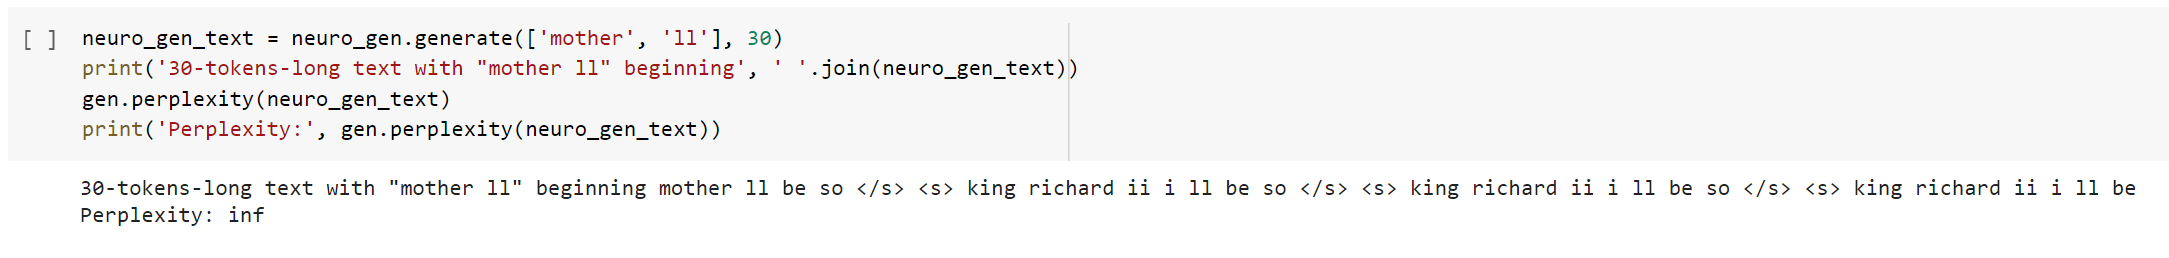

In [ ]:
# 3-grams after 10 epochs
print('Neuronet based on 3-grams')
neuro_gen = NeuroGen(n=3)
neuro_gen.fit(prep_text_short)
neuro_gen_text = neuro_gen.generate(['mother', 'll'], 30)
print('30-tokens-long text with "mother ll" beginning:\n', ' '.join(neuro_gen_text))
gen.perplexity(neuro_gen_text)
print('Perplexity:', gen.perplexity(neuro_gen_text))

Neuronet based on 3-grams
Epoch 1/10
6250/6250 - 68s - loss: 6.2470 - 68s/epoch - 11ms/step
Epoch 2/10
6250/6250 - 69s - loss: 5.7541 - 69s/epoch - 11ms/step
Epoch 3/10
6250/6250 - 66s - loss: 5.5081 - 66s/epoch - 11ms/step
Epoch 4/10
6250/6250 - 66s - loss: 5.3590 - 66s/epoch - 10ms/step
Epoch 5/10
6250/6250 - 66s - loss: 5.2431 - 66s/epoch - 11ms/step
Epoch 6/10
6250/6250 - 68s - loss: 5.1511 - 68s/epoch - 11ms/step
Epoch 7/10
6250/6250 - 67s - loss: 5.0727 - 67s/epoch - 11ms/step
Epoch 8/10
6250/6250 - 66s - loss: 5.0066 - 66s/epoch - 10ms/step
Epoch 9/10
6250/6250 - 66s - loss: 4.9496 - 66s/epoch - 11ms/step
Epoch 10/10
6250/6250 - 67s - loss: 4.8976 - 67s/epoch - 11ms/step
30-tokens-long text with "mother ll" beginning:
 mother ll be a man </s> <s> i am a man </s> <s> i am a man </s> <s> i am a man </s> <s> i am a man </s>
Perplexity: inf


### Comparison

So, after observing  sentences generated by n-gram-model and Neuronet-model, I can assume that n-grams managed the task much better and was fitted much faster than neuronet. N-gram model's sentences are more creative and "natural", but still have not so much sense. 3-grams model is able to create longer syntactic correct sequences of words that can be easily understood bu a human.

Maybe, such an unsatisfied performance of the net could be connected with the amount of data used and/or with the low complexity of the net, but as far as I understood Building complex deep net was not the point of the task.


### Character level for generating

I would also examine n-gram model on character level.

In [ ]:
def convert_tokens_to_characters(tokens: List[str]) -> List[str]:
  characters_list = []
  for token in tokens:
    if token not in ['<s>', '</s>']:
      for char in token:
        characters_list.append(char)
      characters_list.append(' ')
    else:
      characters_list.append(token)
  return characters_list

In [ ]:
prep_chars = convert_tokens_to_characters(prep_text)

In [ ]:
print('Model based on 4-grams')
char_gen = BaseLM(4)
char_gen.fit(prep_chars)

print('Perplexity of "we ll":', char_gen.perplexity(['w', 'e', ' ', 'l', 'l']))

gen_text = char_gen.generate(100, ['w', 'e'], prob_method='prob_with_smoothing')
print('100-chars-long text beginning with "we":', ''.join(gen_text), sep='\n')
char_gen.perplexity(gen_text)
print('Perplexity:', char_gen.perplexity(gen_text))
print('--------------------')

gen_text = char_gen.generate(100, prob_method='prob_with_smoothing')
print('100-chars-long text with empty text_seed:', ''.join(gen_text), sep='\n')
print('Perplexity:', char_gen.perplexity(gen_text))

Model based on 4-grams
Perplexity of "we ll": 9.535800633090133
100-chars-long text beginning with "we":
were to and that calmost if thou dorses i can that words and nighter he lish it and abould your macb
Perplexity: 3.956769794533862
--------------------
100-chars-long text with empty text_seed:
usation fore </s><s>some had ant thou dorses i can that words and nighter he lish it and abould your macb
Perplexity: 4.161217337979212


Here, we can see how some words are actually created of the given characters, but only 4 and less character-long words are meaningful. There are even some connections which are correct in terms of syntax, e.g. "i can".

In [ ]:
print('Model based on 10-grams')
char_gen = BaseLM(10)
char_gen.fit(prep_chars)

print('Perplexity of "we ll see ":', char_gen.perplexity(['w', 'e', ' ', 'l', 'l', ' ', 's', 'e', 'e', ' ']))

gen_text = char_gen.generate(100, ['w', 'e'], prob_method='prob_with_smoothing')

print('100-tokens-long text beginning with "we":', ''.join(gen_text), sep='\n')
char_gen.perplexity(gen_text)
print('Perplexity:', char_gen.perplexity(gen_text))
print('--------------------')

gen_text = char_gen.generate(100, prob_method='prob_with_smoothing')
print('100-tokens-long text with empty text_seed:', ''.join(gen_text), sep='\n')
print('Perplexity:', char_gen.perplexity(gen_text))

Model based on 10-grams
Perplexity of "we ll see ": 8.5
100-tokens-long text beginning with "we":
weoec eain madam juliet </s><s>she s born to undo the deed </s><s>o hateful griefs </s><s>for what i hate but think
Perplexity: inf
--------------------
100-tokens-long text with empty text_seed:
 is one </s><s>macduff i believe him </s><s>duchess of york o illdispersing with interest to try since you cou
Perplexity: 8.422469812320847


Here, there are longer meaningful words and more and longer syntaсtic connections ("she s born to", "what i hate", "i believe him" etc.)